In [1]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [2]:
def branin(X, Y):
    a = 1.0
    b = 5.1 / (4.0 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8.0 * np.pi)
    
    return a * (Y - b * X**2 + c * X - r)**2 + s * (1 - t) * np.cos(X) + s


In [3]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [4]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [5]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 10, 10)
Y = np.random.uniform(0, 15, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [6]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [7]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.95963037 -3.00534208]


In [8]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


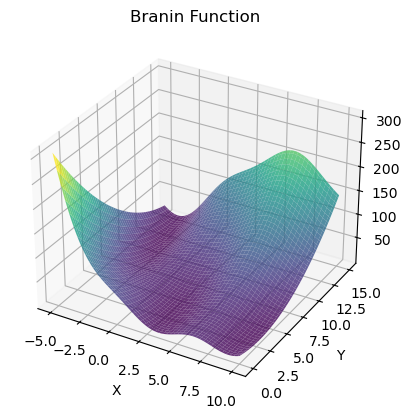

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 10, 100)
y_range = np.linspace(0, 15, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Branin Function')

# Show the plot
plt.show()

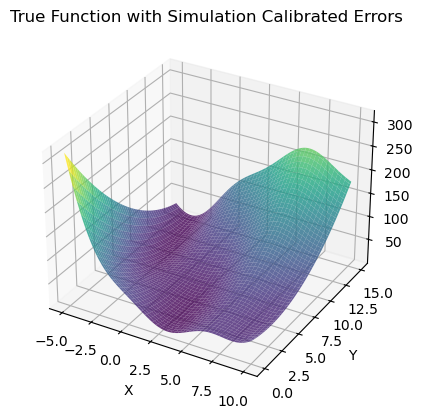

In [10]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[0])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [11]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.05, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=100):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [12]:
def perform_iteration(df):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Normalize outputs
            scaler_y = StandardScaler().fit(y_train)
            y_train_scaled = scaler_y.transform(y_train)
            y_val_scaled = scaler_y.transform(y_val)

            # Train the model
            model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate the model
            y_val_pred_scaled = model.predict(X_val_scaled)
            y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

            score = model.evaluate(X_val_scaled, y_val_pred, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Normalize outputs
    scaler_y = StandardScaler().fit(df[['sim_z']])
    y_scaled = scaler_y.transform(df[['sim_z']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, y_scaled, epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean_scaled, pred_std_scaled = mc_dropout_predictions(best_model, X_scaled)

    # Inverse transform to get predictions back to original scale
    pred_mean = scaler_y.inverse_transform(pred_mean_scaled.reshape(-1, 1)).flatten()
    pred_std = scaler_y.scale_ * pred_std_scaled  # Apply scale factor for std

    x1_range = np.linspace(-5, 10, 100)
    x2_range  = np.linspace(0, 15, 100)

    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Locating global Maximum of predicted mean
    max_index = np.argmax(pred_mean)
    global_max_point = x_grid[max_index]

    # Identify top 10 points with highest uncertainty
    num_new_points = 10
    lhs_sampler = qmc.LatinHypercube(d=2)  # LHS in a 2D space
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to region around global maximum
    scaling_factor = 0.1  # Adjust this factor to control the sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    new_points = np.c_[lhs_x1, lhs_x2]

    # Store new simualted points to validate and sample
    new_points_df = pd.DataFrame(new_points, columns=['x', 'y'])

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot the high uncertainty points
    ax.scatter(new_points[:, 0], new_points[:, 1], pred_mean[max_index], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    # Add validated data points to original data frame
    new_points_df["z"] = branin(new_points_df['x'], new_points_df['y']) + ran_err(num_new_points, 0.05)
    new_points_df["a"] = bo.x_opt[0]
    new_points_df["b"] = bo.x_opt[1]
    new_points_df["sim_z"] = sim_eval(new_points_df["x"], new_points_df["y"], new_points_df["a"], new_points_df["b"])
    new_points_df["diff"] = new_points_df["z"] - new_points_df["sim_z"]

    df = pd.concat([df, new_points_df], axis=0, ignore_index=True)
    return df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

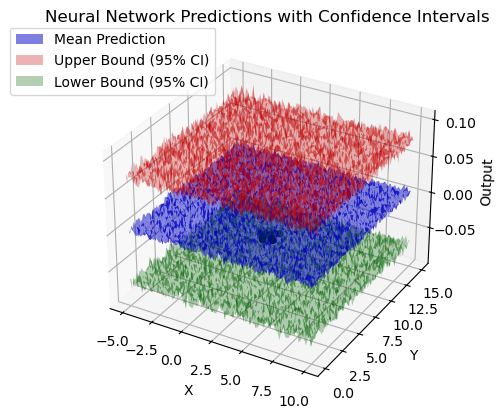

In [13]:
df = perform_iteration(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

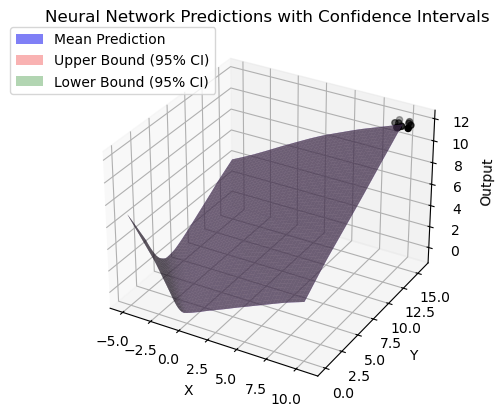

In [14]:
df = perform_iteration(df)

In [15]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

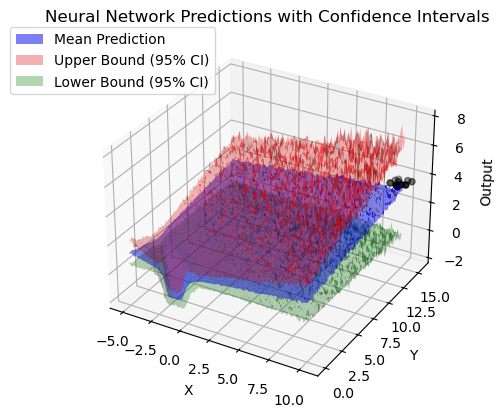

In [16]:
df = perform_iteration(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━

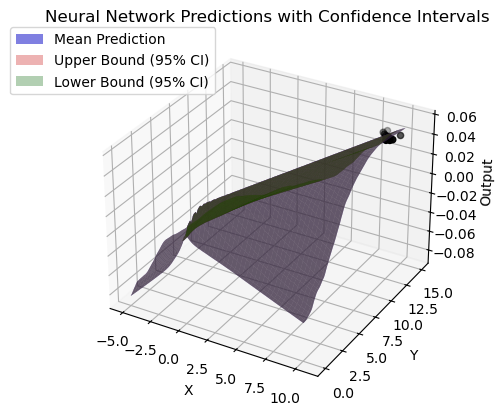

In [17]:
df = perform_iteration(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

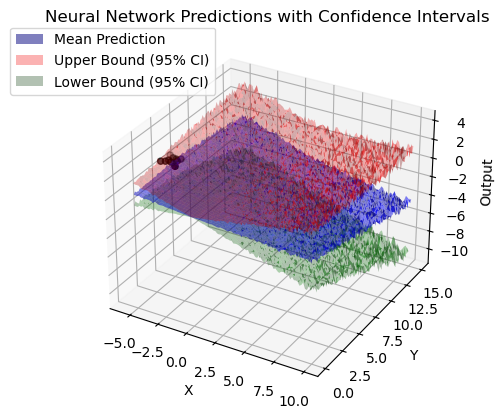

In [18]:
df = perform_iteration(df)

In [19]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574
